# Project: Comparison of Temperature Data for Rosario, Argentina and Birmingham, UK

In [16]:
# Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import ssl
import requests

%matplotlib inline

## Get Data

Data source: Open-Meteo (https://open-meteo.com/). Generated using Copernicus Climate Change Service information (2022). ERA5 data: Hersbach et al. (2018), doi: 10.24381/cds.adbb2d47. ERA5-Land data: Muñoz Sabater (2019), doi: 10.24381/cds.e2161bac. CERRA data: Schimanke et al. (accessed 2022-12-31), doi: 10.24381/cds.622a565a.

Rosario, Santa Fe, Argentine and Birmingham, West Midlands, UK

In [17]:
# API endpoints
endpoints = {
    'rosario_argentina': "https://archive-api.open-meteo.com/v1/archive?latitude=-32.95&longitude=-60.64&start_date=2022-04-01&end_date=2023-03-28&hourly=temperature_2m",
    'birmingham_uk':"https://archive-api.open-meteo.com/v1/archive?latitude=52.48&longitude=-1.90&start_date=2022-04-01&end_date=2023-04-01&hourly=temperature_2m,relativehumidity_2m,rain"
}

# Get data
raw_data = {}
for place, url in endpoints.items():
    response = requests.get(url)

    if response.status_code == 200:
        raw_data[place] = response.json()
        print(place)
        print(raw_data[place].keys())
    else:
        print(f"Error: {response.status_code}")

rosario_argentina
dict_keys(['latitude', 'longitude', 'generationtime_ms', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation', 'elevation', 'hourly_units', 'hourly'])
birmingham_uk
dict_keys(['latitude', 'longitude', 'generationtime_ms', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation', 'elevation', 'hourly_units', 'hourly'])


## Clean and organize dataframe

In [18]:
for place, local_data in raw_data.items():
    print(f"{place}: {str(local_data['hourly'].keys())}\n")

rosario_argentina: dict_keys(['time', 'temperature_2m'])

birmingham_uk: dict_keys(['time', 'temperature_2m', 'relativehumidity_2m', 'rain'])



In [19]:
# Convert the dictionaries to DataFrames and merge them
df_rosario = pd.DataFrame(raw_data['rosario_argentina']['hourly'])
df_birmingham = pd.DataFrame(raw_data['birmingham_uk']['hourly'])

df_combined = pd.merge(df_rosario, df_birmingham, on='time', suffixes=('_rosario', '_birmingham'))


# Extract the time and temperature data into a new DataFrame
df_temp = df_combined[['time', 'temperature_2m_rosario', 'temperature_2m_birmingham']].copy()
df_temp.columns = ['time', 'temperature_rosario', 'temperature_birmingham']
df_temp.head()

,time,temperature_rosario,temperature_birmingham
0,2022-04-01T00:00,15.4,0.3
1,2022-04-01T01:00,15.0,0.2
2,2022-04-01T02:00,14.7,-0.1
3,2022-04-01T03:00,14.3,-0.4
4,2022-04-01T04:00,13.8,-0.5


The resulting `df_temp.head()` I get (note, my data is far more extensive than your example) is as follows:

time	temperature_rosario	temperature_birmingham
0	2023-03-14T00:00	31.7	5.4
1	2023-03-14T01:00	30.8	4.9
2	2023-03-14T02:00	30.1	4.5
3	2023-03-14T03:00	29.5	3.9
4	2023-03-14T04:00	28.9	3.1

From this, I would like to do a scatter plot to compare them.

In [20]:
# Drop rows with null values in the temperature columns
df_temp = df_temp.dropna(subset=['temperature_rosario', 'temperature_birmingham'])
df_temp.head()

,time,temperature_rosario,temperature_birmingham
0,2022-04-01T00:00,15.4,0.3
1,2022-04-01T01:00,15.0,0.2
2,2022-04-01T02:00,14.7,-0.1
3,2022-04-01T03:00,14.3,-0.4
4,2022-04-01T04:00,13.8,-0.5


## Graph the data

In [21]:
# Imports specific to this graph
import matplotlib.dates as mdates

In [22]:
# Convert the 'time' column to a Pandas datetime object and set it as the index
df_temp['time'] = pd.to_datetime(df_temp['time'])
df_temp = df_temp.set_index('time')

By subtracting one standard deviation from the mean and adding one standard deviation to the mean,
we get a range that represents the "normal" temperature range for the given time period.
This range encompasses approximately 68% of the temperature data,
assuming that the data is normally distributed (which may or may not be the case in practice).
Data points that fall outside of this range may be considered abnormal or unusual.


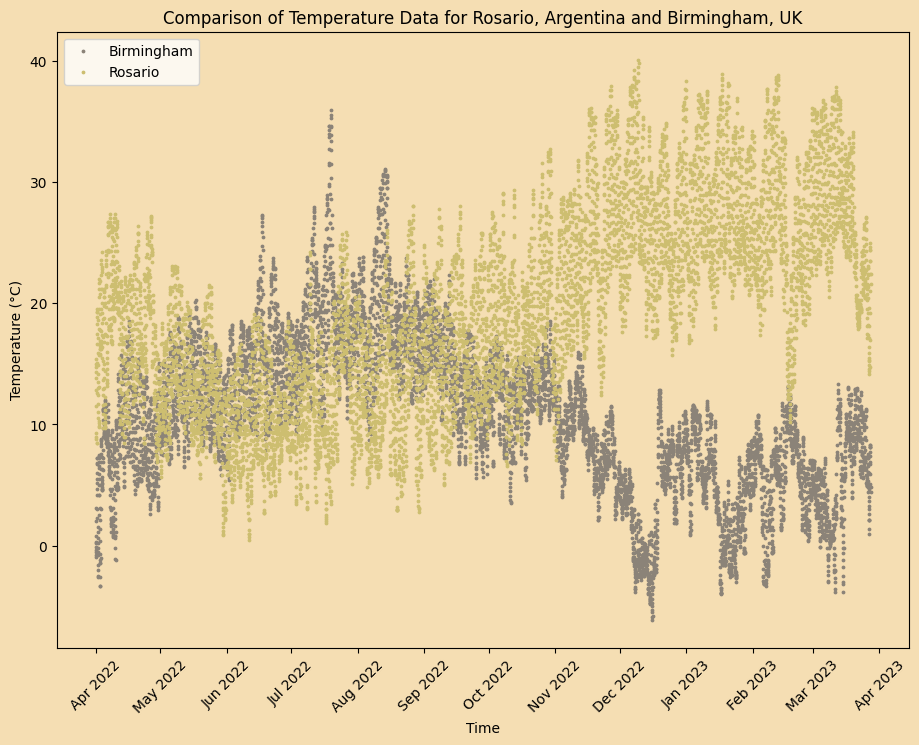

In [30]:
# Define the colors
rosario_color = '#CDBE70'
birmingham_color = '#8B8378'
background_color = '#F5DEB3'

# Get basic statistics for the temperature data
stats_birmingham = df_temp['temperature_birmingham'].describe()
stats_rosario = df_temp['temperature_rosario'].describe()

# Estimate normal temperature ranges for each location
normal_birmingham = (stats_birmingham['mean'] - stats_birmingham['std'], stats_birmingham['mean'] + stats_birmingham['std'])
normal_rosario = (stats_rosario['mean'] - stats_rosario['std'], stats_rosario['mean'] + stats_rosario['std'])


# Set the background color
fig, ax = plt.subplots(figsize=(11, 8))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

# Create a scatter plot of the temperature data
plt.scatter(df_temp.index, df_temp['temperature_birmingham'], c=birmingham_color, label='Birmingham', s=3)
plt.scatter(df_temp.index, df_temp['temperature_rosario'], c=rosario_color, label='Rosario', s=3)

# Set the x-axis ticks to monthly intervals
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Add axis labels and a title
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Comparison of Temperature Data for Rosario, Argentina and Birmingham, UK')

# Get the current x-axis tick locations and labels
xticks = ax.get_xticks()
xlabels = ax.get_xticklabels()

# Rotate the tick labels by 45 degrees
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=45)

# Add a legend
plt.legend()

# Show the plot
plt.show()



## Conclusions


The data is actually interesting.  In the UK, we can see our weather varies far less on a daily basis than it does in Rosario, Argentina.  Is this the mediating effect of having an ocean on all sides?